# Part 1: Twitter Network Analysis

In [37]:
import nltk, re, pprint, community
from nltk import word_tokenize
import requests, zipfile, io, warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from wordcloud import WordCloud

In [2]:
REPUBLICAN = "Republican"
DEMOCRATIC = "Democratic"

# Exercise 1
*Build the network of retweets. We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweet.*

In [3]:
tweet_data_url = 'https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/data_twitter/tweets.zip'
r = requests.get(tweet_data_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

*Consider the 200 most recent tweets written by each member of the house (use the files here, or the ones you produced in Part 1). For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "RT @originalAuthor:", where "originalAuthor" is the handle of the user whose content was retweeted (and the part of the text you want to extract).*

In [4]:
tweets = {}
for name in z.namelist()[1:]:
    handle = name.split('/')[1]
    tweets[handle] = str(z.read(name),'utf-8').split('\n')

In [5]:
congress_data_url = 'https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/data_twitter/H115_tw.csv'
all_members = pd.read_csv(congress_data_url)
twitter_names = list(all_members.tw_name)
dict_name_party = dict(zip(all_members.tw_name, all_members.Party))

*For each retweet, check if the handle retweeted is the one of a member of the house. If yes, keep it. If no, discard it.*

In [6]:
def get_retweet_counts(twitter_names, tweets):
    retweets = dict()
    rt_pattern = r'RT @(\w+)'
    for tn in twitter_names:
        ts = " ".join(tweets[tn])
        handles = re.findall(rt_pattern, ts)
        handles = [h for h in handles if h in twitter_names]
        retweets[tn] = {h: handles.count(h) for h in handles}
    return retweets

In [7]:
retweets = get_retweet_counts(twitter_names, tweets)

*Use a NetworkX DiGraph to store the network. Use weighted edges to account for multiple retweets. Store also the party of each member as a node attribute (use the data in this file, or the data you downloaded in Part 1). Remove self-loops (edges that connect a node with itself).*

In [8]:
# A politcian class for storing data in a neat way.
class Politician:
    def __init__(self, name, party):
        self.TwitterName = name
        self.Party = party
    
    def to_string(self):
        return "TwitterName: %s, Party: %s" % (self.TwitterName, self.Party)
    
    def __hash__(self):
        return hash(self.TwitterName)
    
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.TwitterName == other.TwitterName
               )

In [9]:
DG = nx.DiGraph()

for name in dict_name_party:
    # Create politician node (a)
    a = Politician(name, dict_name_party[name])
    # Check retweets
    a_retweets = retweets[name]
    for author in a_retweets:
        # Check if self-retweet
        if author != name: 
            # Create node (b)
            b = Politician(author, dict_name_party[author])
            # Get link weight, which is the number of times a retweeted b
            weight = a_retweets[author]
            # Add node
            DG.add_edge(a, b, weight=weight)    

## Exercise 2: Visualize the network of retweets and investigate differences between the parties.
*Visualize the network using the Networkx draw function, and nodes coordinates from the force atlas algorithm (see Week 5, Exercise 2). Hint: use the undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements. Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the nodes' size proportional to their total degree.*

In [10]:
UG = DG.to_undirected()
politicians = UG.nodes()
degrees = 2 * np.array(list(dict(UG.degree()).values()))
color_map = []
for p in politicians:
    if p.Party == REPUBLICAN: 
        color_map.append("red")
    elif p.Party == DEMOCRATIC: 
        color_map.append("blue")
    else: 
        color_map.append("black")

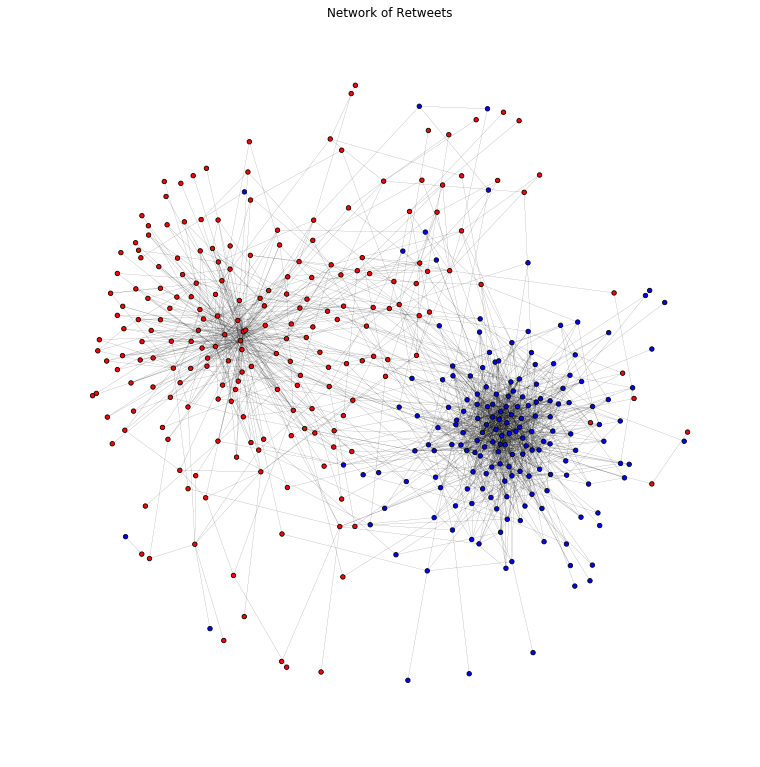

In [11]:
plt.figure(figsize=(10,10));
nx.draw(UG, node_color=color_map, node_size=20, width=0.1, linewidths=0.8, zoom=1.5)
plt.gca().collections[0].set_edgecolor("#000000") 
plt.title("Network of Retweets")
plt.show()

**Question:** Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). Do you observe any difference? How do you explain them?

In [12]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/blogosphere.jpg')

**Answer**: It seems to be the case that just like the WikiPages, there are two big partitions in the graph, representing the parties. Here it means that the politicians retweet other members from their own party.

*Now set the nodes' size proportional to their betweenness centrality.*

**Question:** What do you observe?

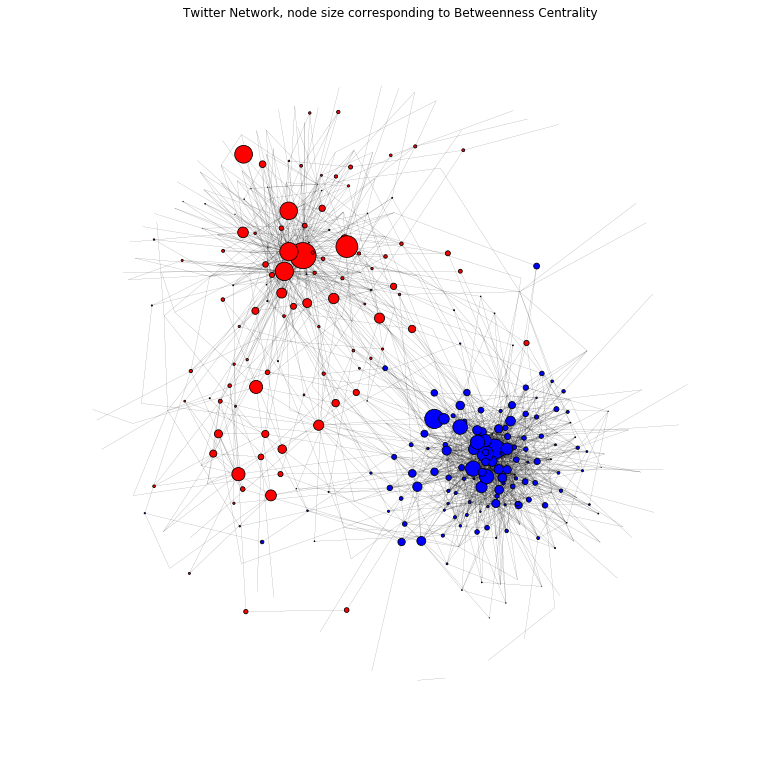

In [13]:
#Compute betweenness centrality measure
B = nx.betweenness_centrality(DG)
B_values = np.array([B[pol] for pol in B])
sizes = 5000 * B_values # factor found through trial and error

plt.figure(figsize=(10,10))
nx.draw(UG, node_color=color_map, node_size=sizes, width=0.1, linewidths=0.8)
plt.gca().collections[0].set_edgecolor("#000000") 
plt.title("Twitter Network, node size corresponding to Betweenness Centrality")
plt.show()

**Answer**: Betweenness is a measure of how often a node acts as a bridge between the shortest path between other nodes in the graph. In this context it can be seen as how active someone is on Twitter, i.e. how many times they retweet another member, or get retweeted by another member.

Therefore, the graph tells us that the republicans have a few very central nodes who are active on Twitter, whereas the activity of the democratic members is distributed more evenly.

**Question:** 
Repeat the point above using eigenvector centrality instead. Is there any difference? Can you explain why?


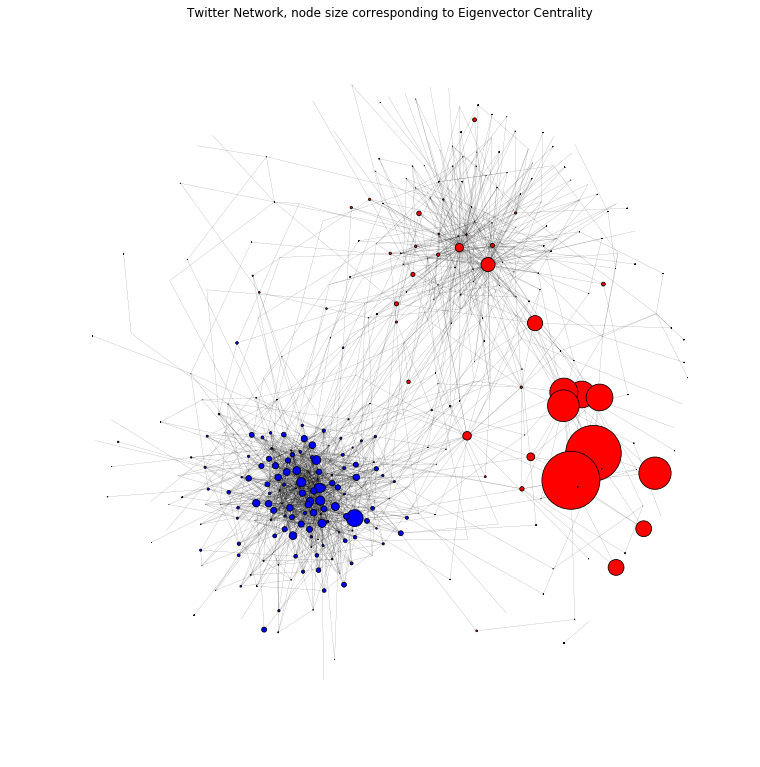

In [17]:
EV = nx.eigenvector_centrality_numpy(DG)
EV_values = np.array([EV[pol] for pol in EV])
sizes = 5000 * EV_values # factor found through trial and error

plt.figure(figsize=(10,10))
nx.draw(UG, node_color=color_map, node_size=sizes, width=0.1, linewidths=0.8)
plt.gca().collections[0].set_edgecolor("#000000") 
plt.title("Twitter Network, node size corresponding to Eigenvector Centrality")
plt.show()

**Answer:** 

The difference in what the two centrality measures represent explains why the graphs look different.
The eigenvector centrality represents the "page rank" which in this case is the number of times a politician was retweeted by a politician who themselves is retweeted a lot. 

The graph therefore tells us that the repubican members have a few of these very credible politicians on Twitter, whereas the democratic members have a very high number of nodes that are retweeted by credible members. This distribution looks somewhat analogous to the betweenness measure, in the way that the democratic members is more evenly distributed than the republican house members.


**Question:** Who are the three nodes with highest degree, eigenvector and betweenness centrality within each party?

In [18]:
# Extract Nodes
nodes = DG.nodes()

# Split nodes on party
repub_nodes = [node for node in nodes if node.Party == REPUBLICAN]
demo_nodes = [node for node in nodes if node.Party == DEMOCRATIC]

**Answer:** Degree Centrality

In [19]:
D = nx.degree(DG)
repub_deg = {pol: D[pol] for pol in repub_nodes}
demo_deg = {pol: D[pol] for pol in demo_nodes}
repub_sortby_deg = sorted(repub_deg, key=repub_deg.get, reverse = True)
demo_sortby_deg = sorted(demo_deg, key=demo_deg.get, reverse = True)

print("Degree Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_deg[i].TwitterName)
    
print("Degree Centrality: Top 3 Democratic Twitter Accounts")
for i in range(3):
    print("\t- " + demo_sortby_deg[i].TwitterName)

Degree Centrality: Top 3 Republican Twitter Accounts
	- SpeakerRyan
	- SteveScalise
	- GOPLeader
Degree Centrality: Top 3 Democratic Twitter Accounts
	- NancyPelosi
	- repmarkpocan
	- WhipHoyer


**Answer:** Eignevector Centrality

In [20]:
repub_ev = {pol: EV[pol] for pol in repub_nodes}
demo_ev = {pol: EV[pol] for pol in demo_nodes}
repub_sortby_ev = sorted(repub_ev, key=repub_ev.get, reverse = True)
demo_sortby_ev = sorted(demo_ev, key=demo_ev.get, reverse = True)

print("Degree EV Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_ev[i].TwitterName)
    
print("Degree EV Centrality: Top 3 Democratic Twitter Accounts")
for i in range(3):
    print("\t- " + demo_sortby_ev[i].TwitterName)

Degree EV Centrality: Top 3 Republican Twitter Accounts
	- RepMarkMeadows
	- Jim_Jordan
	- CongressmanHice
Degree EV Centrality: Top 3 Democratic Twitter Accounts
	- JoaquinCastrotx
	- repmarkpocan
	- NancyPelosi


**Answer:** Betweenness Centrality

In [21]:
repub_b = {pol: B[pol] for pol in repub_nodes}
demo_b = {pol: B[pol] for pol in demo_nodes}
repub_sortby_b = sorted(repub_b, key=repub_b.get, reverse = True)
demo_sortby_b = sorted(demo_b, key=demo_b.get, reverse = True)

print("Degree Betweenness Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_b[i].TwitterName)
    
print("Degree Betweenness Centrality: Top 3 Democratic Twitter Accounts")
for i in range(3):
    print("\t- " + demo_sortby_b[i].TwitterName)

Degree Betweenness Centrality: Top 3 Republican Twitter Accounts
	- SpeakerRyan
	- PatrickMcHenry
	- SteveScalise
Degree Betweenness Centrality: Top 3 Democratic Twitter Accounts
	- NancyPelosi
	- RepDavidEPrice
	- WhipHoyer


*Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes  (e.g. the sum of the weight on outgoing links). *

In [22]:
def sum_retweets(retweets, name):
    rt = retweets[name]
    non_self_rt = {author: rt[author] for author in rt if author != name}
    return sum(non_self_rt.values())

In [23]:
repub_names = list(all_members[all_members.Party == "Republican"].tw_name)
demo_names = list(all_members[all_members.Party == "Democratic"].tw_name)
outgoing_repub = [sum_retweets(retweets, name) for name in repub_names]
outgoing_demo = [sum_retweets(retweets, name) for name in demo_names]

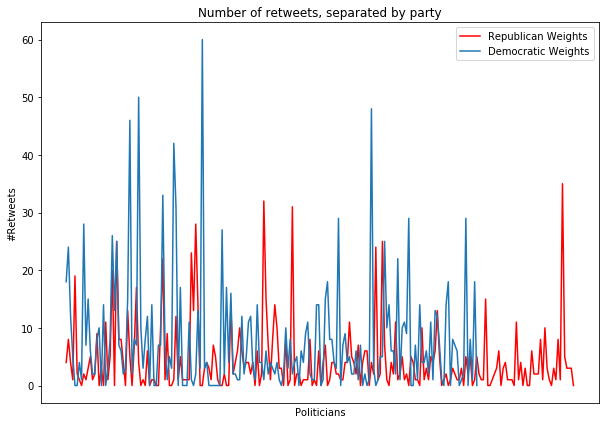

In [24]:
plt.figure(figsize=[10,7])
plt.plot(outgoing_repub, "red")
plt.plot(outgoing_demo)
plt.legend(["Republican Weights", "Democratic Weights"])
plt.title("Number of retweets, separated by party")
plt.xlabel("Politicians"); plt.ylabel("#Retweets"); plt.xticks([], []);
plt.show()

**Question:** Which party is more active in retweeting other members of the house?

In [25]:
avg_repub = sum(outgoing_repub) / len(outgoing_repub)
print("Avg. retweets per member (Republican): %.2f" % avg_repub)

Avg. retweets per member (Republican): 4.37


In [26]:
avg_demo = sum(outgoing_demo) / len(outgoing_demo)
print("Avg. retweets per member (Democratic): %.2f" % avg_demo)

Avg. retweets per member (Democratic): 7.80


**Answer:** The democrats are on average twice as active when it comes to retweeting other members of the house of representatives.

*Find the 3 members of the republican party that have retweeted more often tweets from democratic members.*

In [27]:
#Calculate the ratio of cross party retweets / total number retweets
def sum_cross_retweets(retweets, mapping, name):
    party = mapping[name]
    rt = retweets[name]
    total_rt = sum([rt[author] for author in rt if author != name])
    cross_rt = {
        author: rt[author] for author in rt 
        if author != name and mapping[author] != party # Check if name and party is different
    }
    if total_rt == 0:
        return 0
    else:
        return sum(cross_rt.values()) / total_rt
 

In [28]:
cross_repub = {name: sum_cross_retweets(retweets, dict_name_party, name) for name in repub_names}
cross_demo = {name: sum_cross_retweets(retweets, dict_name_party, name) for name in demo_names}

cross_repub_sorted = sorted(cross_repub, key=cross_repub.get, reverse=True)
cross_demo_sorted = sorted(cross_demo, key=cross_demo.get, reverse=True)

In [29]:
print("Cross-retweeting (Republican party), top 3")
for i in range(3):
    print("\t-" + cross_repub_sorted[i])

Cross-retweeting (Republican party), top 3
	-RepFredUpton
	-RepTomReed
	-RepTomMarino


* https://en.wikipedia.org/wiki/Fred_Upton
* https://en.wikipedia.org/wiki/Tom_Reed_(politician)
* https://en.wikipedia.org/wiki/Tom_Marino

*Repeat the measure for the democratic members. *

In [30]:
print("Cross-retweeting (Democratic party), top 3")
for i in range(3):
    print("\t-" + cross_demo_sorted[i])

Cross-retweeting (Democratic party), top 3
	-RepRoybalAllard
	-daveloebsack
	-RepSwalwell


* https://en.wikipedia.org/wiki/Lucille_Roybal-Allard
* https://en.wikipedia.org/wiki/Dave_Loebsack
* https://en.wikipedia.org/wiki/Eric_Swalwell

**Question:** Can you explain your results by looking at the Wikipedia pages of these members of the house?

**Answer:** One possible explanation for why some of these individuals retweet the opposite party is because they represent their party in a state that leans towards the party opposite of their district. This is definitely true of Dave Loebsack who is the only Democratic representative in Iowa and Tom Reed in a Republican representative in the quite Democratic state of New York.

### Exercise 3: Community Detection

**Question:** Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network? Comment on your result.

In [40]:
full_part = community.best_partition(UG)
full_mod = community.modularity(full_part, UG)
print('The best partition\'s modularity is %f' % full_mod)

The best partition's modularity is 0.471562


**Answer:** Both modularities are above zero, meaning it is possible for the retweets to represent two communities.

For the WikiPedia network, the modularity was found to be $M_{wiki} = 0.45$ which is very close to $M_{twitter} = 0.47$.

This means that both WikiPedia links and retweets on Twitter can be used as a foundation for communties in the graph, with retweets being slightly better for this dataset.

* Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). 
* This time assign each node a different color based on their community. 
* Describe the structure you observe.

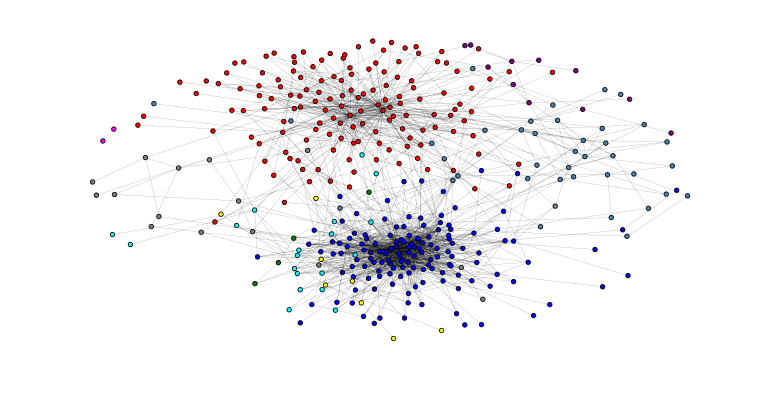

In [41]:
colors = ["blue", "cyan", "yellow", "green", "red", "steelblue", "purple", "gray", "magenta"]
communities = list(full_part.values())
color_list = [colors[com] for com in communities]

plt.figure(figsize=[10,5])
nx.draw(UG, node_color=color_list, node_size=20, width=0.1, linewidths=0.8)
plt.gca().collections[0].set_edgecolor("#000000") 
plt.show()

*Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.*

In [42]:
B = 2
C = len(set(communities))
D = np.zeros((B,C))
parties = [0 if n.Party == REPUBLICAN else 1 for n in nodes]

for p,c in zip(parties, communities):
    D[p,c] += 1

**Question:** Plot the confusion matrix and explain how well the communities you've detected correspond to the parties. Consider the following questions:
Are there any republicans grouped with democrats (and vice versa)?

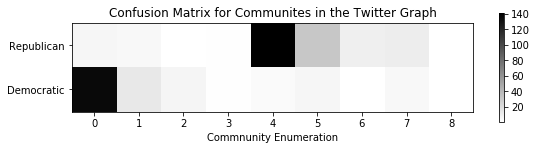

In [43]:
import matplotlib.cm as cm
plt.figure(figsize=[9,2])
plt.imshow(D, cmap=cm.binary)
plt.yticks(np.arange(2), ["Republican", "Democratic"])
plt.grid(False)
plt.colorbar()
plt.title("Confusion Matrix for Communites in the Twitter Graph")
plt.xlabel("Commnunity Enumeration")
plt.show()

**Answer:** Overall the the two bigger communities (0 and 4) are very disjoint, i.e. they contain a lot of members from only one party. There are smaller communities such as 1, 5 and 7 which contain few members, but where the party distribution is much more equal.

**Question:** Does the community detection algorithm sub-divide the parties?

**Answer**: The community detection algorithm appears to slightly sub-divide the parties but there still exist two large and partisan communities with seemingly no members grouped in from the opposite party. Some of the small dusb-divisions appear to maybe have some slight overlap. The current American political situation is extremely divided by party lines which this clearly shows. 

**Question:** Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

**Answer**: The subdivisions may be due to entities such as congressional caucuses like the Freedom Caucas who organize to pursue more extreme legislature.


## Part 2: What do republican and democratic members tweet about?

### Exercise 4:

*Create two large documents, one for the democratic and one for the republican party.* 
* Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
* Exclude all twitter handles.
* Exclude punctuation.
* Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
* Exclude numbers (since they're difficult to interpret in the word cloud).
* Set everything to lower case.
* Compute the TF-IDF for each document

In [44]:
tokenized_tweets_dem  = []
tokenized_tweets_rep = []

for party,handle in zip(all_members['Party'],all_members['tw_name']):
    for txt in tweets[handle]:
        #Exclude hashtags, urls, @s, the retweet term RT, and rep names
        txt = re.sub(r'(Rep. .*?\s)|(\sRT\s)|(\sRM\s)|(@.*?\s)|(https.*?($|\s))' , ' ', txt)
        #Tokenize
        txt = word_tokenize(txt)
        #Remove stopwords, handles
        toRemove = nltk.corpus.stopwords.words('english') + list(all_members['tw_name'])
        #Lowercase and remove non alphabetic tokens
        txt = [t.lower() for t in txt if t not in toRemove and re.search('^[a-zA-Z]+$',t)]
        if party == 'Democratic':
            tokenized_tweets_dem += txt
        elif party == 'Republican':
            tokenized_tweets_rep += txt

In [45]:
def tf_idf(doc1, doc2, N=2):
    # TF
    fd = nltk.FreqDist(doc1)
    sorted_tokens = [x[0] for x in fd.most_common()]
    tf = np.array([x[1] for x in fd.most_common()])

    # IDF
    set1, set2 = set(doc1), set(doc2)
    df = np.array([(t in set1) + (t in set2) for t in sorted_tokens])
    idf = np.log(N / df)
    
    # TFIDF
    return tf * idf, sorted_tokens

def make_wordcloud(tokens, tfidf, title):
    # Round scores
    tfidf_rounded = np.array(tfidf, dtype="int32")
    document = " ".join([(w + " ") * n for w,n in zip(tokens, tfidf_rounded)])
    
    # Plot
    wc = WordCloud(
        background_color="white", 
        max_words=4000, contour_width=3, 
        contour_color='steelblue', 
        collocations=False
    ).generate(document)

    plt.figure(figsize=[10,5])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

**Question:** Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.

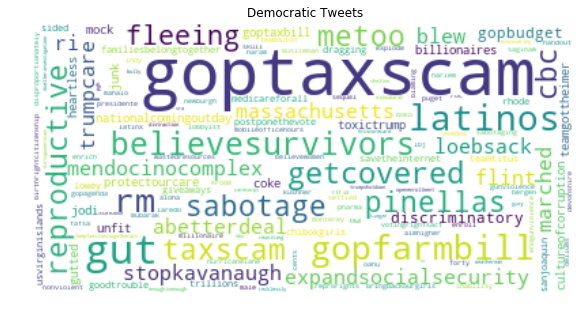

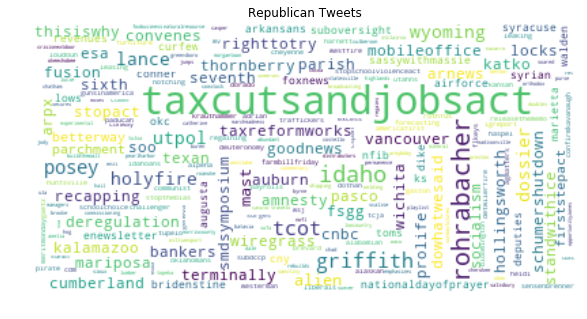

In [46]:
TFIDF_dem,sorted_tokens_dem = tf_idf(tokenized_tweets_dem, tokenized_tweets_rep)
TFIDF_rep,sorted_tokens_rep = tf_idf(tokenized_tweets_rep, tokenized_tweets_dem)

make_wordcloud(sorted_tokens_dem,TFIDF_dem,'Democratic Tweets')
make_wordcloud(sorted_tokens_rep,TFIDF_rep,'Republican Tweets')

**Answer:** These topics are indeed less "boring" as they come from tweets rather than wikipedia pages. So, they concern the current and relevant topics that the representatives want their constituents to know about. Either mainstream news events (ie. expressing condolences for the victims in the shooring in Pittsburg) or controversial political topics (ie. health care), especially as the midterms near. They are also the topics that will incite emotion and galvanize people to get out and vote.


## Part 3: Sentiment analysis

### Exercise 5:

**Question:** Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.

**Answer:** The list was generated following a study of university undergraduates. A variety of words were shown to them and the subjects related those words to a set of feelings, which then was translated into a happiness value.

In [47]:
import csv
sentiment = requests.get('https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001').text
reader = csv.reader(io.StringIO(sentiment), delimiter='\t')
lines = [l for l in reader]
header = lines[3]
data = lines[4:]
sentiment_dict = {}
for line in data:
    sentiment_dict[line[0]] = float(line[2])

*Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).*

In [48]:
def calculate_sentiment(tokens, labMT):
    return np.sum([labMT[t] for t in tokens if t in labMT.keys()])

def calculate_sentiment_norm(tokens, labMT):
    sentiments = [labMT[t] for t in tokens if t in labMT.keys()]
    if not sentiments:
        return 0 # if empty
    return np.mean(sentiments)
  

*Create two lists: one including the tweets written by democratic members, and the other including the tweets written by republican members (in the text files, tweets are separated by newlines).*


In [49]:
def get_tweets(account_name):
    base_url = "https://raw.githubusercontent.com/thomasnilsson/02805-dataset/master/tweets/"
    url = base_url + account_name
    req = requests.get(url)
    return req.text

In [50]:
tweets_repub = [get_tweets(name) for name in dict_name_party if dict_name_party[name] == REPUBLICAN]
tweets_demo = [get_tweets(name) for name in dict_name_party if dict_name_party[name] == DEMOCRATIC]

In [51]:
def extract_tokens(doc, bad_words):
    bad_words = nltk.corpus.stopwords.words('english') + bad_words
    doc_lower = doc.lower()
    pattern = r'(Rep. .*?\s)|(\sRT\s)|(\sRM\s)|(@.*?\s)|(https.*?($|\s))'
    no_tag = re.sub(pattern , ' ', doc_lower)
    tokens = word_tokenize(no_tag)
    tokens = [t for t in tokens if t not in bad_words and re.search('^[a-zA-Z]+$',t)]
    return tokens

repub_tweet_tokens = [
    extract_tokens(tweet, twitter_names) 
    for collection in tweets_repub
    for tweet in collection.split("\n") 
]

demo_tweet_tokens = [
    extract_tokens(tweet, twitter_names) 
    for collection in tweets_demo
    for tweet in collection.split("\n") 
]

sentiment_rep = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in repub_tweet_tokens
]

sentiment_dem = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in demo_tweet_tokens
]

sentiment_rep_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in repub_tweet_tokens
]

sentiment_dem_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in demo_tweet_tokens
]

In [52]:
sentiment_dem = []
sentiment_rep = []
tokenized_tweets_dem  = []
tokenized_tweets_rep = []

for party,handle in zip(all_members['Party'],all_members['tw_name']):
    for txt in tweets[handle]:
    #Exclude hashtags, urls, @s, the retweet term RT, and rep names
    txt = re.sub(r'(Rep. .*?\s)|(\sRT\s)|(\sRM\s)|(@.*?\s)|(https.*?($|\s))' , ' ', txt)
    #Tokenize
    txt = word_tokenize(txt)
    #Remove stopwords and handles
    toRemove = nltk.corpus.stopwords.words('english') + list(all_members['tw_name'])
    #Lowercase and remove non alphabetic tokens
    txt = [t.lower() for t in txt if t not in toRemove and re.search('^[a-zA-Z]+$',t)]
    sentiment = calculate_sentiment(txt,sentiment_dict)
    if party == 'Democratic' and sentiment > 0:
        sentiment_dem.append(sentiment)
        tokenized_tweets_dem.append(txt)
    elif party == 'Republican' and sentiment > 0:
        sentiment_rep.append(sentiment)
        tokenized_tweets_rep.append(txt)

IndentationError: expected an indented block (<ipython-input-52-5afb2fea1ddc>, line 9)

**Question:** Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.hist(sentiment_rep, color="red", bins=100, edgecolor="black")
plt.title("Republican sentiment score per tweet")
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")

plt.subplot(1,2,2)
plt.hist(sentiment_dem, color="steelblue", bins=100, edgecolor="black")
plt.title("Democratic sentiment score per tweet")
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")
plt.show()

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.hist(sentiment_rep_normalized, color="red", edgecolor="black", bins=100)
plt.title("Republican normalized sentiment score per tweet")
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")

plt.subplot(1,2,2)
plt.hist(sentiment_dem_normalized, color="steelblue", edgecolor="black", bins=100)
plt.title("Democratic normalized sentiment score per tweet")
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")
plt.show()

**Answer:** It seems that both parties are close to equal in the distribution of their sentiment scores density-wise, however the Republican party has a slight edge in terms number of tweets with a high sentiment score.


*Compute the average m and standard deviation $\sigma$ of the tweets sentiment (considering tweets by both republican and democrats).*

In [ ]:
avg = np.mean(sentiment_dem + sentiment_rep)
std = np.std(sentiment_dem + sentiment_rep)

*Now consider only tweets with sentiment lower than m-2$\sigma$. We will refer to them as negative tweets. Build a list containing the negative tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 5). Create a word-cloud for each of them.*

**Question:** Comment on the differences between the negative contents posted by republicans and democrats.

In [ ]:
#Negative Tweets:
neg_thresh = avg - 2*std

neg_tweets_dem = []
for sent, tweet in zip(sentiment_dem,tokenized_tweets_dem):
    if sent <= neg_thresh:
        neg_tweets_dem += tweet

neg_tweets_rep = []
for sent, tweet in zip(sentiment_rep,tokenized_tweets_rep):
    if sent <= neg_thresh:
        neg_tweets_rep += tweet
        
neg_TFIDF_dem,sorted_tokens_dem = tf_idf(neg_tweets_dem, neg_tweets_rep)
neg_TFIDF_rep,sorted_tokens_rep = tf_idf(neg_tweets_rep, neg_tweets_dem)

make_wordcloud(sorted_tokens_dem,neg_TFIDF_dem,'Democratic Negative Tweets')
make_wordcloud(sorted_tokens_rep,neg_TFIDF_rep,'Republican Negative Tweets')

**Question:** Repeat the point above, but considering positive tweets instead (e.g. with sentiment larger than m+2$\sigma$). Comment on your results.

In [ ]:
#Positive Tweets:
pos_thresh = avg + 2*std

pos_tweets_dem = []
for sent, tweet in zip(sentiment_dem,tokenized_tweets_dem):
    if sent >= pos_thresh:
        pos_tweets_dem += tweet

pos_tweets_rep = []
for sent, tweet in zip(sentiment_rep,tokenized_tweets_rep):
    if sent >= pos_thresh:
        pos_tweets_rep += tweet
        
pos_TFIDF_dem,sorted_tokens_dem = tf_idf(pos_tweets_dem, pos_tweets_rep)
pos_TFIDF_rep,sorted_tokens_rep = tf_idf(pos_tweets_rep, pos_tweets_dem)

make_wordcloud(sorted_tokens_dem,pos_TFIDF_dem,'Democratic Positive Tweets')
make_wordcloud(sorted_tokens_rep,pos_TFIDF_rep,'Republican Positive Tweets')